# Olist project : customer segmentation  
## Data cleaning and exploratory work 

The idea is to understand the different clients profile form Olist client dataset.
The notebook contains cleaning and exploratory work on OLIST dataset and include : 
- The merging of different databases
- Data cleaning :
    - Handling of missing data
    - Filtering of clients that ordered more than once
    - other filtering 
- Exploratory work based on :
    - What and when do costumer order ? 
    - How long are they waiting to receive there order ? 
    - Where are they from ? 
    - How do they pay? 
- Feature engineering based on marketing criteria : RFM and other features


In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import datetime

from translate import Translator
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from geopy import distance

import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

warnings.simplefilter(action="ignore",
                      category=SettingWithCopyWarning)

In [3]:
olist_customers = pd.read_csv("olist_customers_dataset.csv", low_memory=False)

datalist_geolocation = pd.read_csv("olist_geolocation_dataset.csv",
                                   low_memory=False)

olist_order_items = pd.read_csv("olist_order_items_dataset.csv",
                                low_memory=False)

olist_order_payments = pd.read_csv("olist_order_payments_dataset.csv",
                                   low_memory=False)

olist_order_reviews = pd.read_csv("olist_order_reviews_dataset.csv",
                                  low_memory=False)

olist_orders = pd.read_csv("olist_orders_dataset.csv", low_memory=False)

olist_products = pd.read_csv("olist_products_dataset.csv", low_memory=False)

olist_sellers = pd.read_csv("olist_sellers_dataset.csv", low_memory=False)

In [4]:
eData = olist_orders.merge(olist_order_items, on="order_id", how="left")
eData = eData.merge(olist_order_payments, on="order_id", how="outer",
                    validate="m:m")
eData = eData.merge(olist_order_reviews, on="order_id", how="outer")
eData = eData.merge(olist_products, on="product_id", how="outer")
eData = eData.merge(olist_customers, on="customer_id", how="outer")
eData = eData.merge(olist_sellers, on="seller_id", how="outer")

In [5]:
eData.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state'],
      dtype='object')

In [6]:
eData.shape

(119143, 39)

In [7]:
eData.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


# Handling missing data


In [8]:
print("Number of missing values per variable: \n")
NaNColumns = eData.isna().sum()
for i in range(len(NaNColumns)):
    if NaNColumns[i] != 0:
        print(
            f"{str(NaNColumns.index[i]):<40}",
            round(NaNColumns.loc[NaNColumns.index[i]]
                  / eData.shape[0] * 100, 3),
            "%",
        )

Number of missing values per variable: 

order_approved_at                        0.149 %
order_delivered_carrier_date             1.751 %
order_delivered_customer_date            2.871 %
order_item_id                            0.699 %
product_id                               0.699 %
seller_id                                0.699 %
shipping_limit_date                      0.699 %
price                                    0.699 %
freight_value                            0.699 %
payment_sequential                       0.003 %
payment_type                             0.003 %
payment_installments                     0.003 %
payment_value                            0.003 %
review_id                                0.837 %
review_score                             0.837 %
review_comment_title                     88.259 %
review_comment_message                   57.828 %
review_creation_date                     0.837 %
review_answer_timestamp                  0.837 %
product_category_name     

delete columns with more than 50 % missing values 

In [9]:
eData.drop(columns=["review_comment_title",
                    "review_comment_message"], inplace=True)

drop product that have more thant 70 % missing values and product with  NaN on small percent of dataset

In [10]:
# # drop product that have more than 80% missing values
eData.dropna(thresh=int(eData.shape[1] * 0.7), axis=0, inplace=True)
eData.dropna(subset=["review_id"], inplace=True)
eData.dropna(subset=["product_category_name"], inplace=True)
eData.dropna(subset=["product_weight_g"], inplace=True)

handling date values

In [11]:
eData["date_purchase"] = pd.to_datetime(eData["order_purchase_timestamp"])
eData["order_approved_at_dt"] = pd.to_datetime(eData["order_approved_at"])
eData["order_delivered_carrier_date_dt"] = pd.to_datetime(
    eData["order_delivered_carrier_date"]
)
eData["order_delivered_customer_date_dt"] = pd.to_datetime(
    eData["order_delivered_customer_date"]
)
eData["order_estimated_delivery_date_dt"] = pd.to_datetime(
    eData["order_estimated_delivery_date"]
)
eData.drop(
    columns=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ],
    inplace=True,
)

replace dates missing values by known dates and mean interval time on the dataset.

In [12]:

eData.loc[eData["order_approved_at_dt"].isna(), "order_approved_at_dt"] \
    = eData["date_purchase"] + \
    np.abs(np.mean(eData["order_approved_at_dt"] - eData["date_purchase"]))

eData.loc[
    eData["order_delivered_customer_date_dt"].isna(),
    "order_delivered_customer_date_dt"] \
        = eData["order_approved_at_dt"] + np.abs(np.mean(
            eData["order_approved_at_dt"] -
            eData["order_delivered_customer_date_dt"]
            ))

eData.loc[
    eData["order_delivered_carrier_date_dt"].isna(),
    "order_delivered_carrier_date_dt"
    ] = eData["order_approved_at_dt"] + np.abs(np.mean(
        eData["order_approved_at_dt"] -
        eData["order_delivered_carrier_date_dt"]
    ))

In [13]:
eData.drop(eData[eData["payment_type"] == "not_defined"].index, inplace=True)

In [14]:
eData.isna().sum().sum()

12

## Filtering : 


In [15]:
eData["date_purchase"].dt.year.value_counts()

2018    62741
2017    52511
2016      384
Name: date_purchase, dtype: int64

most of the data comes from 2017 and 2018, we wil drop the ones from 2016. 

In [16]:
eData.drop(eData[eData["date_purchase"].dt.year == 2016].index, inplace=True)

###  Costumers ids and number of orders and items
Only keep costumers that bought more than once on the website as requested.


In [17]:
print("Number of customer_id : ", len(eData["customer_id"].unique()))
print("Number of customer_unique_id : ",
      len(eData["customer_unique_id"].unique()))
print("Number of order_id : ", len(eData["order_id"].unique()))

Number of customer_id :  96232
Number of customer_unique_id :  93124
Number of order_id :  96232


The number of customer_id is the same as the order. A costumer_id must be attributed at each order whereas customer_unique_id correspond to a client account. 

In [18]:
eData.value_counts(["customer_unique_id"]).describe()

count    93124.000000
mean         1.237619
std          0.847359
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         75.000000
dtype: float64

Each costumer bought between 1 and 75 products, most of them only bought one time. 
 

In [19]:
eData.value_counts("order_id").describe()

count    96232.000000
mean         1.197647
std          0.748758
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         63.000000
dtype: float64

There are between 1 to 63 items in each order, most of them are only one items per orders.

## Only keep the customer that ordered more than once 

In [20]:
numberOfItems = eData.groupby(["customer_unique_id", "order_id"]).size()
numberOfOrders = numberOfItems.groupby("customer_unique_id").size()
costumers_by_more_than_1 = numberOfOrders[numberOfOrders > 1].index

In [21]:
cData = eData[eData["customer_unique_id"].isin(costumers_by_more_than_1)]

In [22]:
print("Percentage of clients that ordered more than once : ",
      round(len(costumers_by_more_than_1) / eData.shape[0], 3))

Percentage of clients that ordered more than once :  0.024


## Exploratory work : some questions to better understand the dataset : 
- When do costumer oder ther most ? 
- From where are they from ? 
- Who are they buying from and from where? 
- How are they paying ? 
- What product are bought the most ? 
- How long are thery wiating for their items ? 

# What type of product do costumers oder the most ? 

Most bought product type : 

In [23]:
groupsPerCategory = cData.groupby("product_category_name")
MostBoughtProducts = (groupsPerCategory
                      .count()
                      .sort_values("order_id", ascending=False)
                      .head(10))
MostBoughtProducts["percentage"] = (round(
    MostBoughtProducts["order_id"] /
    groupsPerCategory.count().sum()["order_id"],
    2))
MostBoughtProducts["cumul_percentage"] = \
    MostBoughtProducts["percentage"].cumsum()
MostBoughtProducts = MostBoughtProducts.reset_index()


Let's translate these categories into english to better understand what there are referring too: 

In [24]:
translator = Translator(from_lang="pt", to_lang="en")
names = (
    groupsPerCategory.count()
    .sort_values("order_id", ascending=False)
    .head(10)
    .index.to_list()
)
dic = {}
for name in names:
    translation = translator.translate(name)
    dic[name] = translation

MostBoughtProducts["product_category_name_translation"] = \
    MostBoughtProducts["product_category_name"].map(dic)
MostBoughtProducts[["product_category_name_translation",
                    "product_category_name", "order_id",
                    "percentage", "cumul_percentage"]]

,product_category_name_translation,product_category_name,order_id,percentage,cumul_percentage
0,bed_table_bath,cama_mesa_banho,1307,0.16,0.16
1,furniture_decoration,moveis_decoracao,905,0.11,0.27
2,Sports and Recreation,esporte_lazer,752,0.09,0.36
3,informatica_acessorios,informatica_acessorios,611,0.07,0.43
4,beauty_health,beleza_saude,602,0.07,0.50
5,housewares,utilidades_domesticas,475,0.06,0.56
6,watches_gifts,relogios_presentes,329,0.04,0.60
7,tools_garden,ferramentas_jardim,306,0.04,0.64
8,fashion_bags_and_accessories,fashion_bolsas_e_acessorios,284,0.03,0.67
9,telephony,telefonia,234,0.03,0.70


70 % of the sales are contained in 10 products types while half of the sales correspond to 5 product categories. Most of product bought on olist sites correspond to housewares and beauty.

## When do costumer buy these product  ?

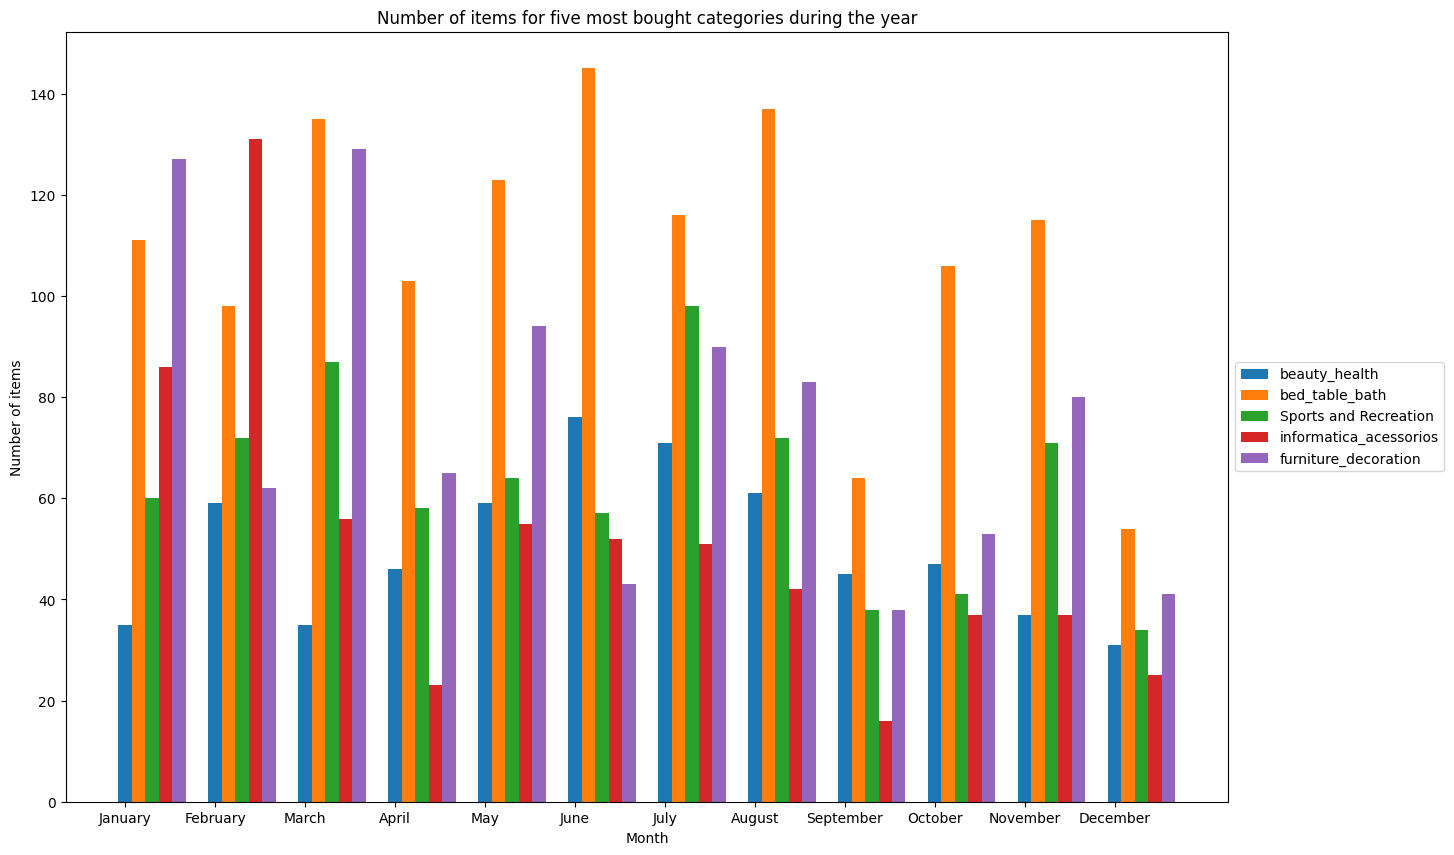

In [25]:
months = np.array([i for i in range(1, 13)])
barWidth = 0.15
idx = 0
plt.figure(figsize=(15, 10))
for name, group in groupsPerCategory:
    if name in names[:5]:
        sales = group["date_purchase"].dt.month.value_counts().sort_index()
        plt.bar(months + idx * barWidth,
                sales, width=barWidth,
                label=dic[name])
        idx = idx + 1
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("Number of items")
plt.xticks(
    months,
    [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ],
)
plt.xlabel("Month")
plt.title("Number of items for five most bought categories during the year")
plt.show()

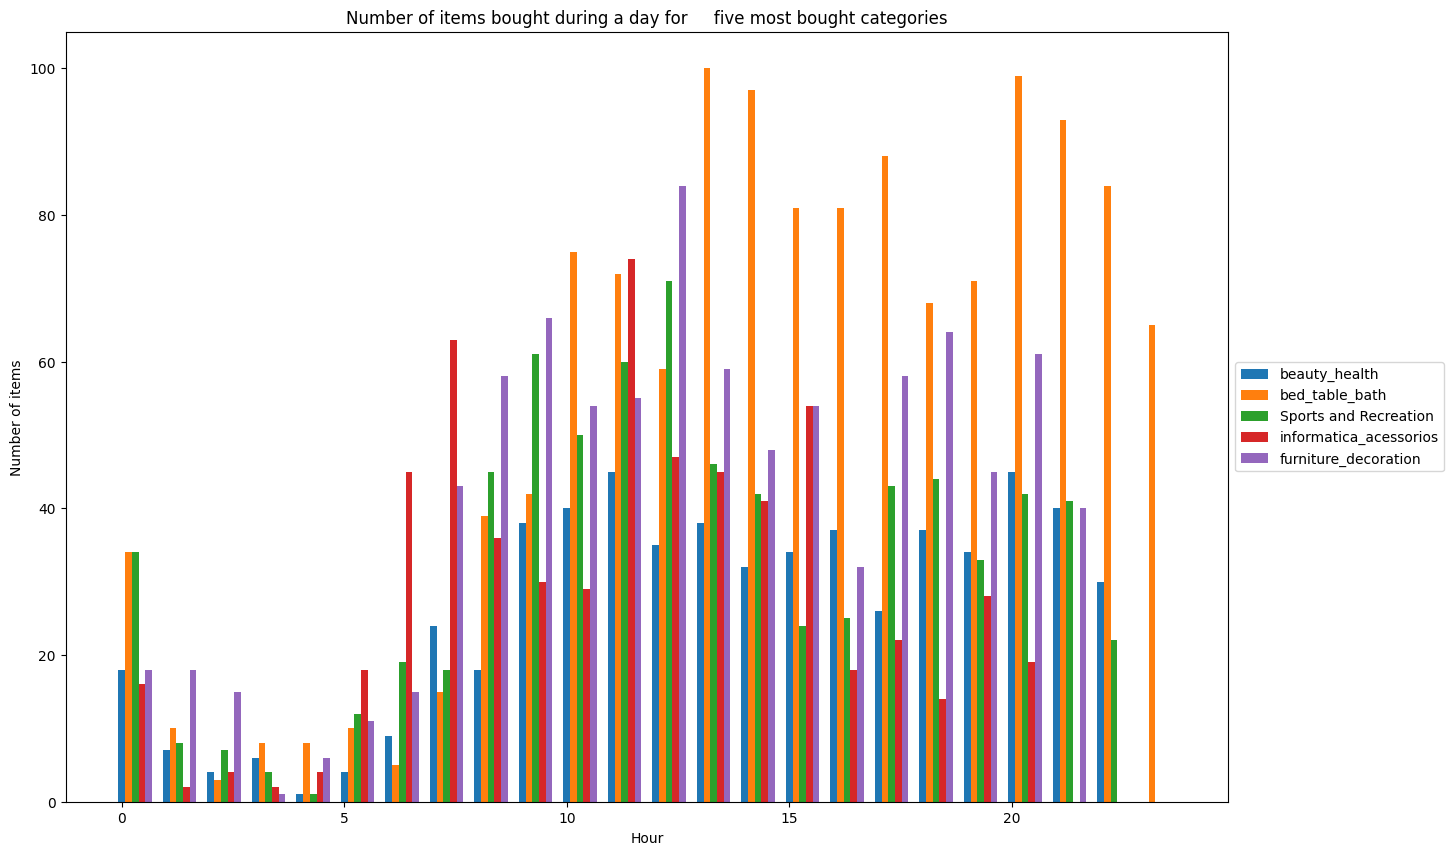

In [26]:
hours = np.array([i for i in range(24)])
barWidth = 0.15
idx = 0
plt.figure(figsize=(15, 10))
for name, group in groupsPerCategory:
    if name in names[:5]:
        sales = group["date_purchase"].dt.hour.value_counts().sort_index()
        if len(sales.index) != 24:  # no sales at this hour
            for i in hours:
                if i not in sales.index:
                    sales[i] = 0
        plt.bar(hours + idx * barWidth,
                sales,
                width=barWidth,
                label=dic[name])
        idx = idx + 1
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("Number of items")
plt.xlabel("Hour")
plt.title("Number of items bought during a day for \
    five most bought categories")
plt.show()

Most of items are ordered around lunch time or after 8pm, some categories such as computer accessories are ordered more during working hours whereas sport, decoration and furniture have a similar orders distribution during the day. 


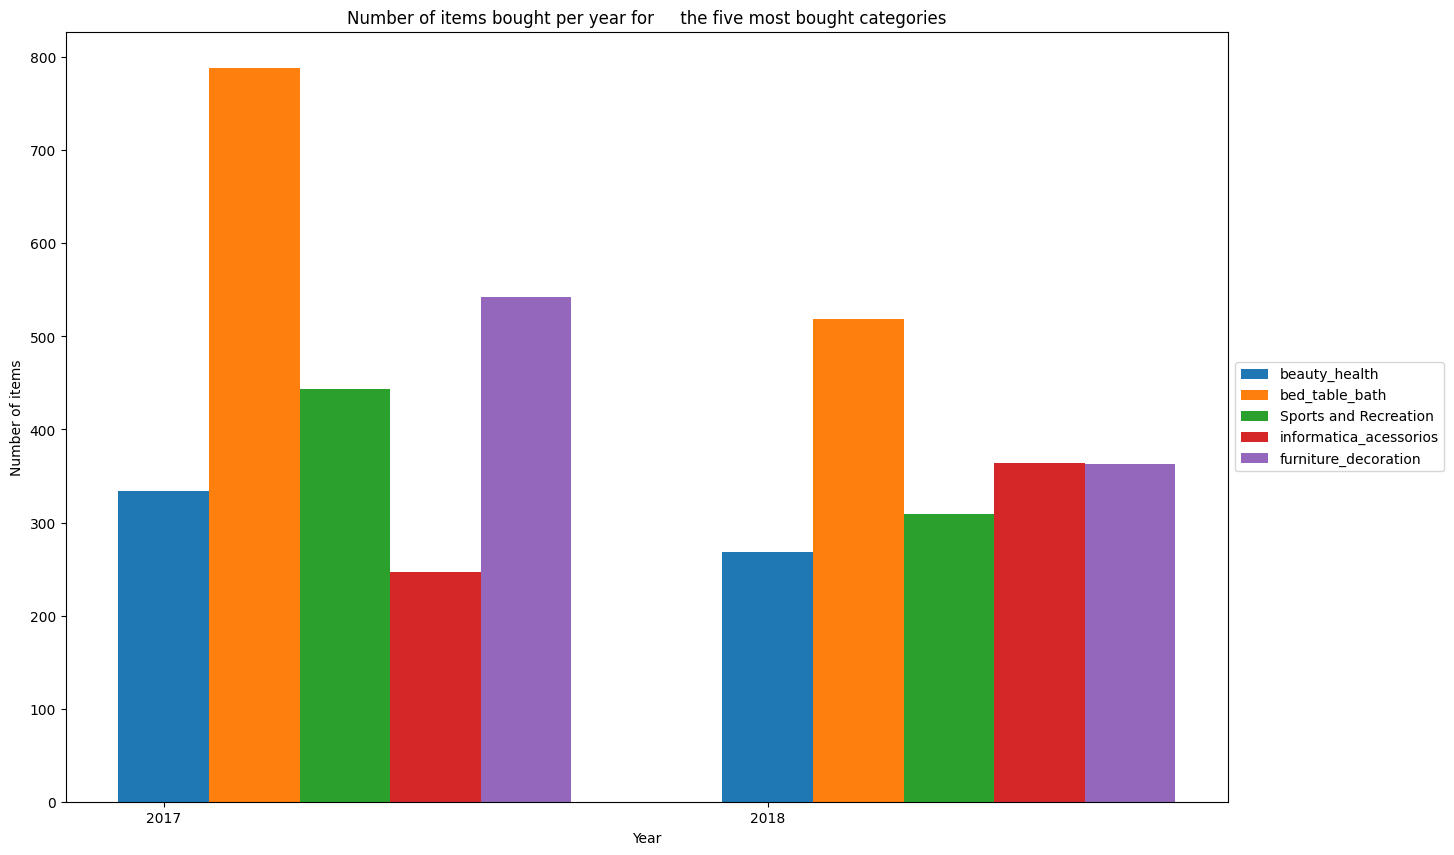

In [27]:
years = np.array([2017, 2018])
barWidth = 0.15
idx = 0
plt.figure(figsize=(15, 10))
for name, group in groupsPerCategory:
    if name in names[:5]:
        sales = group["date_purchase"].dt.year.value_counts().sort_index()
        if len(sales.index) != 2:  # no sales at this hour
            for i in years:
                if i not in sales.index:
                    sales[i] = 0
        plt.bar(years + idx * barWidth, sales, width=barWidth, label=dic[name])
        idx = idx + 1
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("Number of items")
plt.xlabel("Year")
plt.xticks([2017, 2018])
plt.title("Number of items bought per year for \
    the five most bought categories")
plt.show()

Sales clearly decrease for most of the five most bought categories  expect  for informatical accessories.
Let's see in teh trend in global around all products.  

In [28]:
sales = cData["date_purchase"].dt.year.value_counts().sort_index()
sales2017 = sales[sales.index == 2017].values[0]
sales2018 = sales[sales.index == 2018].values[0]
TotalSalesPrices2017 = round((
      cData[cData["date_purchase"].dt.year == 2017]["price"].sum()))
TotalSalesPrices2018 = round(
    cData[cData["date_purchase"].dt.year == 2018]["price"].sum()
    )
d = [
    [sales2017, TotalSalesPrices2017],
    [sales2018, TotalSalesPrices2018],
    [
        round(abs(sales2017 - sales2018) / sales2018 * 100),
        round(
            abs(TotalSalesPrices2017 - TotalSalesPrices2018) /
            TotalSalesPrices2018 * 100)
    ]
]

# Create the pandas DataFrame
df = pd.DataFrame(
    d, index=['2017', '2018', 'Decrease (%)'],
    columns=["Number of Items", "Total sale price (in Brazilian Real)"]
)
df

,Number of Items,Total sale price (in Brazilian Real)
2017,4288,431734
2018,3883,392357
Decrease (%),10,10


The number of items ordered clearly decrease from 2017 to 2018, the total price of the sales also by 10%.

# How long are costumer waiting for there order   ?

In [29]:
cData["order_delivered_customer_date_dt"].sub(
    cData["date_purchase"], axis=0).describe()

count                          8171
mean     12 days 02:50:13.051165557
std       8 days 03:17:18.377425047
min                 1 days 00:57:16
25%          6 days 20:14:53.500000
50%                10 days 10:47:41
75%                15 days 01:38:38
max                88 days 05:48:05
dtype: object

Costumers wait between 1 to 88 ays to receive there order. Half of them receive there oder before 10 days after there online purchase.

#  From where are they from ? 

In [30]:
costumerInfo = cData.groupby("customer_unique_id").first()
costumersCity = np.array(costumerInfo["customer_city"].to_list())
costumersCity = np.unique(costumersCity)

In [31]:
CtNot = 0
CntYes = 0
available_city = datalist_geolocation["geolocation_city"].unique()
costumersCity = np.array(costumerInfo["customer_city"].to_list())
costumersCity = np.unique(costumersCity)
alreadySeen = []
customersLocation = pd.DataFrame(columns=["city", "lat", "lng"])
for city in costumersCity:
    if city in available_city and city not in alreadySeen:
        CntYes = CntYes + 1
        lat = datalist_geolocation[
            datalist_geolocation["geolocation_city"] == city
        ].iloc[0]["geolocation_lat"]
        lng = datalist_geolocation[
            datalist_geolocation["geolocation_city"] == city
        ].iloc[0]["geolocation_lng"]
        customersLocation = customersLocation.append(
            {
                "city": city,
                "lat": lat,
                "lng": lng,
            },
            ignore_index=True,
        )
        alreadySeen.append(city)
    else:
        CtNot = CtNot + 1
print(CntYes)
print(CtNot)

760
0


In [32]:
customersLocation.to_csv("customersLocation.csv", index=False)

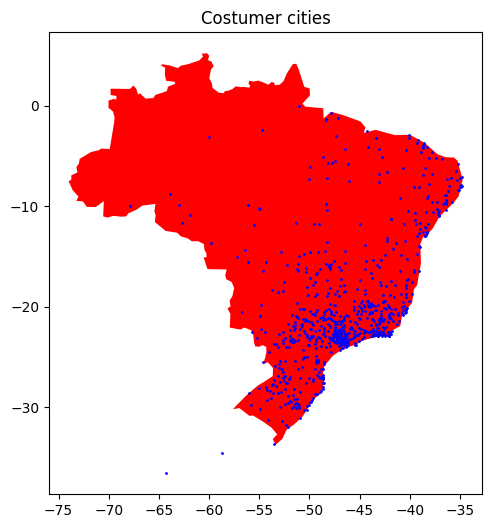

In [33]:
geometry = [Point(xy) for xy in zip(customersLocation["lng"],
                                    customersLocation["lat"])]
gdf = GeoDataFrame(customersLocation, geometry=geometry)

# this is a simple map that goes with geopandas

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
brazil = world[world["name"] == "Brazil"]
# plot the customer locations on the map, with Brazil zoomed in
ax = brazil.plot(figsize=(10, 6),
                 marker="o",
                 color="red",
                 markersize=15)
gdf.plot(ax=ax, marker="o", color="blue", markersize=1)
# ax.set_xlim([-85, -30])
# ax.set_ylim([-40, 10])
plt.title("Costumer cities")
plt.show()

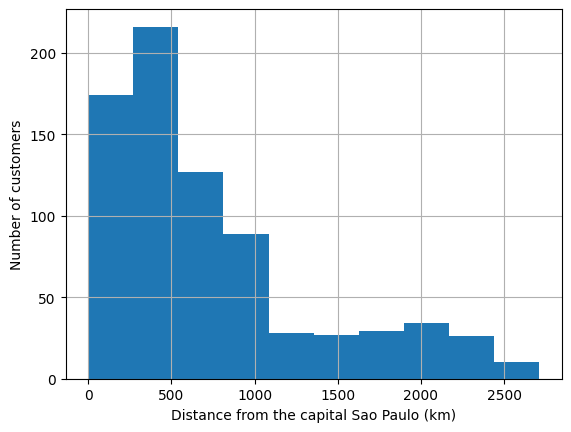

In [34]:
# rio_lat = (customersLocation[customersLocation["city"] == "rio de janeiro"]
#                  .lat.values[0])
# rio_lng = (customersLocation[customersLocation["city"] == "rio de janeiro"]
#                  .lng.values[0])
sao_paulo_lat = (customersLocation[customersLocation["city"] == 'sao paulo']
                 .lat.values[0])
sao_paulo_lng = (customersLocation[customersLocation["city"] == 'sao paulo']
                 .lng.values[0])

dist = []
for index, row in customersLocation.iterrows():
    distance_km = (distance.distance(
        (sao_paulo_lat, sao_paulo_lng),
        (row['lat'], row['lng']))
                   .km)
    dist.append(distance_km)
customersLocation['DistFromCapital'] = dist
customersLocation['DistFromCapital'].hist()
plt.xlabel("Distance from the capital Sao Paulo (km)")
plt.ylabel("Number of customers")
plt.show()

Almost all costumer live in Bresil, most costumers live close to Sao Paulo and Rio de Janeiro. 

# Payments

In [35]:
cData[['price', 'freight_value',
       'payment_sequential', 'payment_type',
       'payment_installments',
       'payment_value']]

,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,29.99,8.72,1.0,credit_card,1.0,18.12
1,29.99,8.72,3.0,voucher,1.0,2.00
2,29.99,8.72,2.0,voucher,1.0,18.59
29,24.90,11.85,1.0,credit_card,1.0,36.75
45,46.80,67.70,1.0,credit_card,1.0,127.45
...,...,...,...,...,...,...
119002,55.00,7.87,1.0,boleto,1.0,62.87
119003,29.90,38.14,1.0,boleto,1.0,68.04
119029,22.20,10.96,1.0,credit_card,3.0,33.16
119099,67.50,35.79,1.0,credit_card,7.0,103.29


Instalment payments refer to a customer paying a bill in small portions throughout a fixed period of time.

number of customers 

In [36]:
cData[["payment_installments", "payment_sequential"]].describe()

,payment_installments,payment_sequential
count,8171.000000,8171.000000
mean,3.304736,1.181496
std,3.091410,1.214450
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,1.000000
75%,5.000000,1.000000
max,21.000000,21.000000


We need to combine orders (one line per product per order §??? ) 

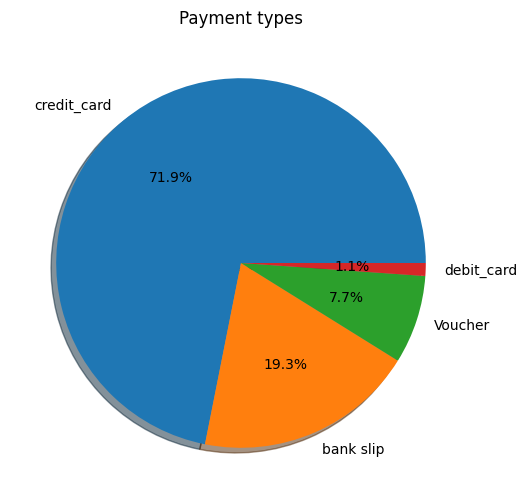

In [37]:
s = cData.value_counts("payment_type")

s.plot.pie(subplots=True,
           labels=[translator.translate(i) for i in s.index],
           shadow=True,
           autopct='%1.1f%%',
           figsize=(11, 6))

plt.ylabel("")
plt.title("Payment types")
plt.show()

# Feature engineering : 
First save database, before feature engineering for segmentation 
update and ARIs calculation 

In [38]:
cData.to_csv("cData.csv", index=False)

# New varaibles : RFM 
- Recency  : date of last order
- Frequency  : of orders 
- Monetary value : total value of purchases


In [39]:

cData = eData[eData["customer_unique_id"].isin(costumers_by_more_than_1)]
col = ["recency",	"frequency",	"montant"]
clientDataBase = pd.DataFrame()

it means that the more the "recency" variable is high is more recent the costumer did an order 

In [40]:
def datetime_to_float(d, date0):

    # convert to Unix timestamp (in seconds)
    timestamp = (d - date0) / np.timedelta64(1, "s")

    # convert to float
    float_timestamp = float(timestamp)

    return float_timestamp

In [41]:
orderTimePerClient = \
    cData.groupby("customer_unique_id")["date_purchase"].unique()
date0 = np.min(cData["date_purchase"])
for clientID in orderTimePerClient.index:
    lastOrderTime = np.max(orderTimePerClient[clientID])
    cData.loc[
        cData["customer_unique_id"] == clientID, "recency"
    ] = datetime_to_float(lastOrderTime, date0)

numberOfItems = round(cData.groupby("customer_unique_id")["order_id"]
                      .count() / cData
                      .groupby("customer_unique_id")["order_id"]
                      .nunique())
for clientID in numberOfItems.index:
    cData.loc[
        cData["customer_unique_id"] == clientID, "frequency"
    ] = numberOfItems[clientID]

MontantPerClient = cData.groupby("customer_unique_id")["price"].sum()
for clientID in MontantPerClient.index:
    cData.loc[
        cData["customer_unique_id"] == clientID, "montant"
    ] = MontantPerClient[clientID]

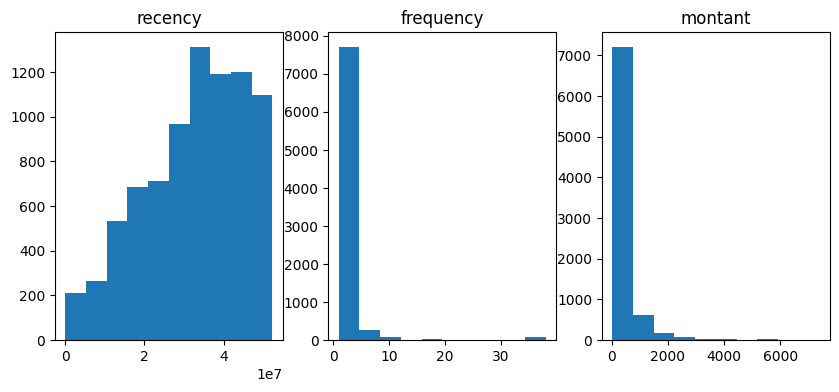

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].hist(cData["recency"])
axs[0].set_title("recency")
axs[1].hist(cData["frequency"])
axs[1].set_title("frequency")
axs[2].hist(cData["montant"])
axs[2].set_title("montant")
plt.show()

There are clearly outliers, we want to get rid of atypical values without loosing the one far from the median, that have a lot of importance as costumer who buy a lot and for high value really interest the company. 

remove outliers : 

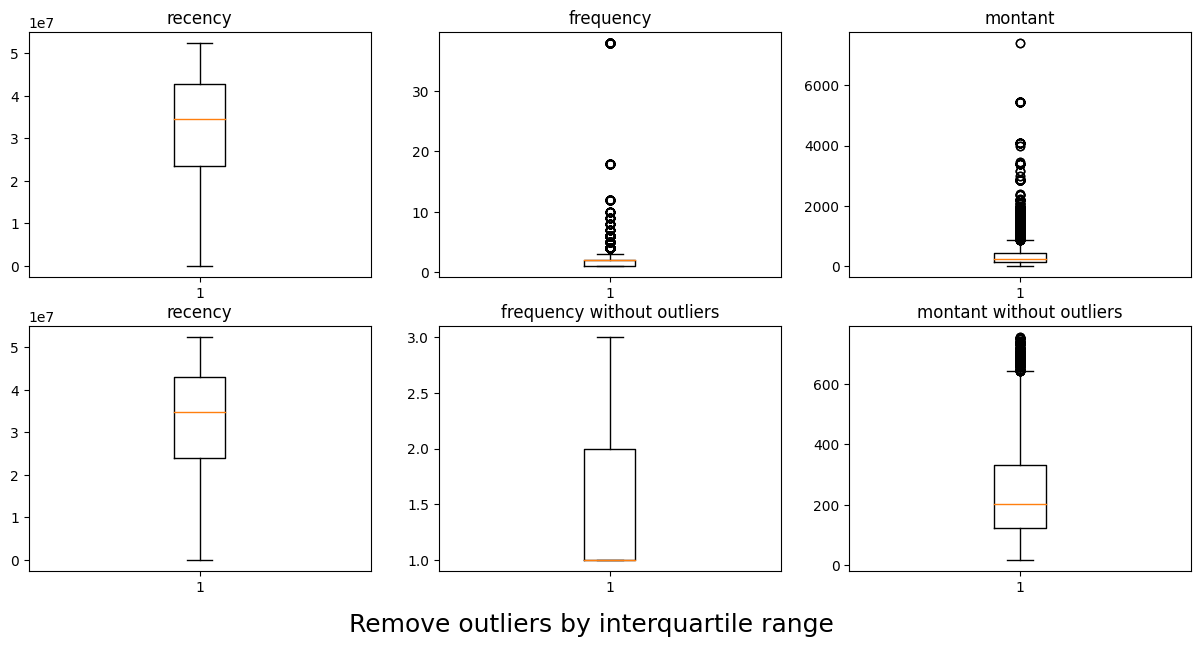

In [43]:
# Remove outliers
def drop_interquartile_outliers(column, dataFrame):
    Q3 = np.quantile(column, 0.75)
    Q1 = np.quantile(column, 0.25)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    mask = (column < lower_range) | (column > upper_range)
    dataFrame.drop(column.loc[mask].index, inplace=True)


fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0][0].boxplot(cData["recency"])
axs[0][0].set_title("recency")
axs[0][1].boxplot(cData["frequency"])
axs[0][1].set_title("frequency")
axs[0][2].boxplot(cData["montant"])
axs[0][2].set_title("montant")
fData = cData[col]
drop_interquartile_outliers(fData["frequency"], fData)
drop_interquartile_outliers(fData["montant"], fData)

axs[1][0].boxplot(fData["recency"])
axs[1][0].set_title("recency")
axs[1][1].boxplot(fData["frequency"])
axs[1][1].set_title("frequency without outliers")
axs[1][2].boxplot(fData["montant"])
axs[1][2].set_title("montant without outliers")
plt.suptitle("Remove outliers by interquartile range", y=0.05, fontsize=18)
plt.show()

In [44]:
round((cData.shape[0] - fData.shape[0]) / cData.shape[0], 3)

0.159

Here the we loose 15% of the individuals, which is a lot. 

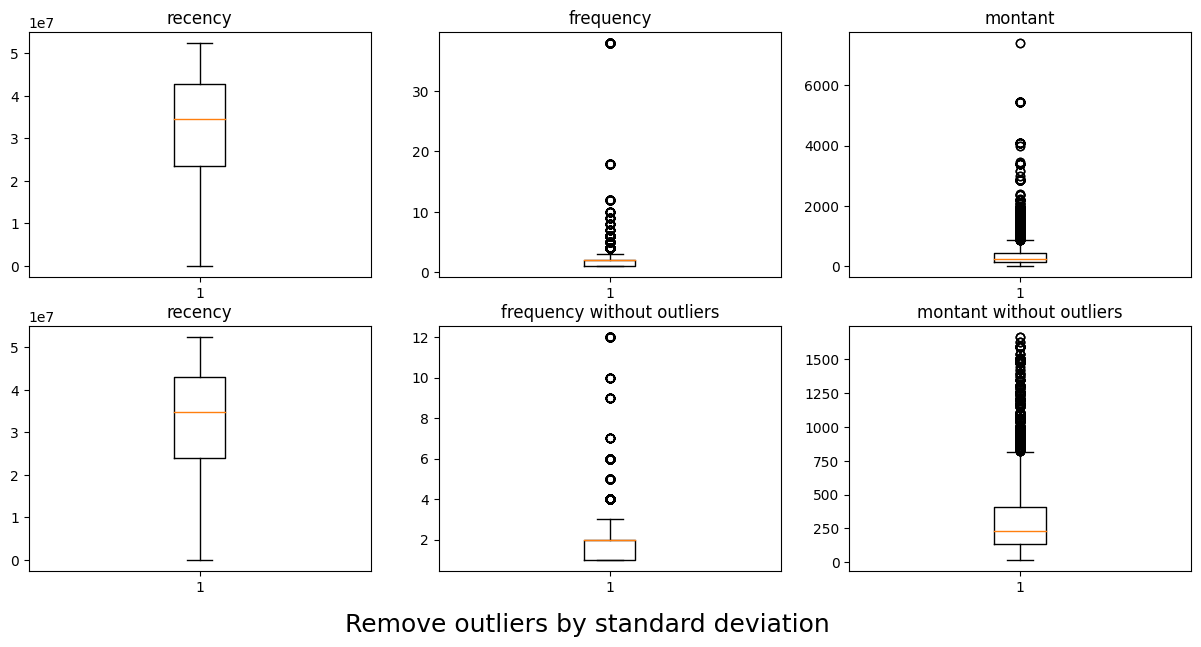

In [45]:
# Remove outliers, N being the number multiplying the standard deviation
# If the data follows normal distribution than :
#  Standard Deviation from the Mean: 68%
#  Standard Deviations from the Mean: 95%
#  Standard Deviations from the Mean: 99.7%

def drop_stdOutliers_outliers(column, dataFrame, N=3):
    lower_range = np.mean(column) - N*np.std(column)
    upper_range = np.mean(column) + N*np.std(column)
    mask = (column < lower_range) | (column > upper_range)
    dataFrame.drop(column.loc[mask].index, inplace=True)


fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0][0].boxplot(cData["recency"])
axs[0][0].set_title("recency")
axs[0][1].boxplot(cData["frequency"])
axs[0][1].set_title("frequency")
axs[0][2].boxplot(cData["montant"])
axs[0][2].set_title("montant")

fData = cData[col]

drop_stdOutliers_outliers(fData["frequency"], fData)
drop_stdOutliers_outliers(fData["montant"], fData)

axs[1][0].boxplot(fData["recency"])
axs[1][0].set_title("recency")
axs[1][1].boxplot(fData["frequency"])
axs[1][1].set_title("frequency without outliers")
axs[1][2].boxplot(fData["montant"])
axs[1][2].set_title("montant without outliers")
plt.suptitle("Remove outliers by standard deviation ", y=0.05, fontsize=18)
plt.show()

In [46]:
round((cData.shape[0] - fData.shape[0]) / cData.shape[0], 3)

0.033

So here we choose to remove outliers using standard deviation rule, the range being the mean +/- 3 * standard deviation , as we assume the variable to follow a gaussian-like distribution, than we should keep over 99.7% for each variable. The percentage of data loss is about 3% as the data does not follow exactly normal distribution. 

frequency is complex : for now number of orders 

In [47]:
drop_stdOutliers_outliers(cData["frequency"], cData)
drop_stdOutliers_outliers(cData["montant"], cData)

In [48]:
cData.loc[:, "frequency_lg"] = np.log(cData.loc[:, "frequency"])
cData.loc[:, "recency_bx"], fitted_lambda = \
    stats.boxcox(cData.loc[:, "recency"])
cData.loc[:, "montant_bx"], fitted_lambda = \
    stats.boxcox(cData.loc[:, "montant"])

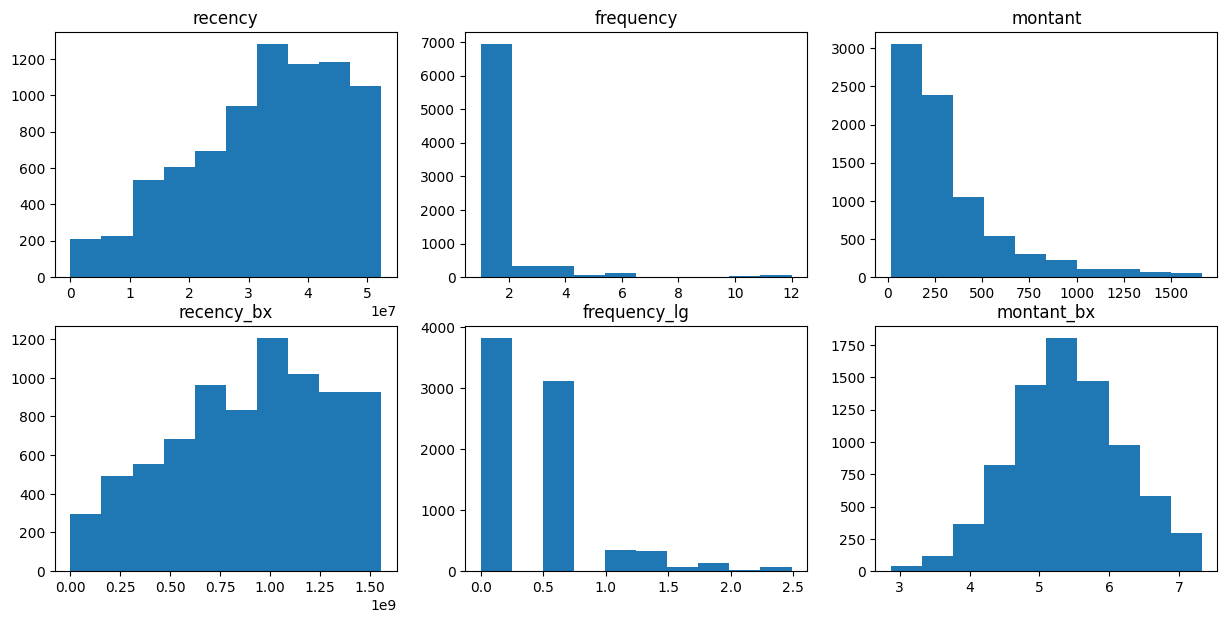

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0][0].hist(cData["recency"])
axs[0][0].set_title("recency")
axs[0][1].hist(cData["frequency"])
axs[0][1].set_title("frequency")
axs[0][2].hist(cData["montant"])
axs[0][2].set_title("montant")

axs[1][0].hist(cData["recency_bx"])
axs[1][0].set_title("recency_bx")
axs[1][1].hist(cData["frequency_lg"])
axs[1][1].set_title("frequency_lg")
axs[1][2].hist(cData["montant_bx"])
axs[1][2].set_title("montant_bx")
plt.show()

In [50]:
col = ["recency_bx", "frequency_lg", "montant_bx"]
pd.set_option('mode.chained_assignment', None)
scaler = MinMaxScaler()  # Standardization
cData.loc[:, col] = scaler.fit_transform(cData.loc[:, col])

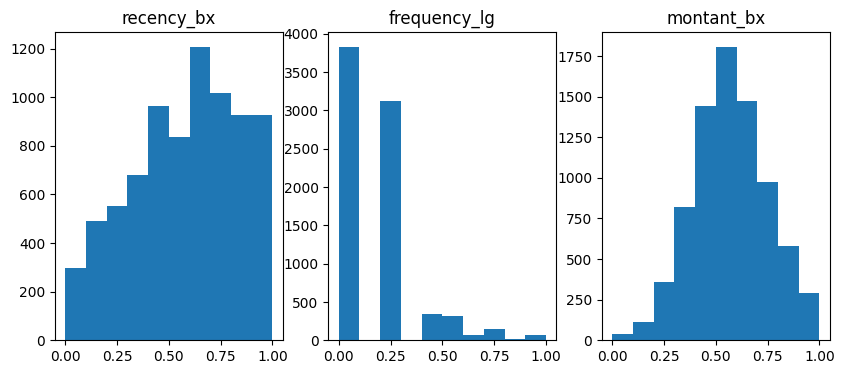

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].hist(cData["recency_bx"])
axs[0].set_title("recency_bx")
axs[1].hist(cData["frequency_lg"])
axs[1].set_title("frequency_lg")
axs[2].hist(cData["montant_bx"])
axs[2].set_title("montant_bx")
plt.show()

In [52]:
clients = (
    cData.groupby("customer_unique_id")
    .first()[["recency_bx", "frequency_lg", "montant_bx"]]
    .reset_index()
    )

clients.to_csv("clients.csv", index=False)

# RFM + specific criteria 

In [53]:

sao_paulo_lat = (customersLocation[customersLocation["city"] == 'sao paulo']
                 .lat.values[0])
sao_paulo_lng = (customersLocation[customersLocation["city"] == 'sao paulo']
                 .lng.values[0])

dist = []
for index, row in customersLocation.iterrows():
    distance_km = (distance.distance(
        (sao_paulo_lat, sao_paulo_lng),
        (row['lat'], row['lng']))
                   .km)
    dist.append(distance_km)
customersLocation['DistFromCapital'] = dist


for index, row in customersLocation.iterrows():
    cData.loc[cData['customer_city'] == row['city'],
              "costumer_dist_from_capital"] = \
        row["DistFromCapital"]

customersLocation['DistFromCapital'].mean()
cData.loc[cData["costumer_dist_from_capital"].isna(),
          "costumer_dist_from_capital"] = \
    customersLocation['DistFromCapital'].mean()

In [54]:
col = ['costumer_dist_from_capital', 'review_score',
       'payment_installments']
RFM = ["recency_bx", "frequency_lg", "montant_bx"]

In [55]:
clientsPlus = (
    cData.groupby("customer_unique_id")
    .first()[RFM + col]
    .reset_index()
)

paymentGroups = \
    cData.groupby("customer_unique_id")["payment_installments"].mean()

clientsPlus.loc[clientsPlus["customer_unique_id"] == paymentGroups.index,
                "payment_installments"] = paymentGroups.values

reviewGroups = cData.groupby("customer_unique_id")["review_score"].mean()
clientsPlus.loc[clientsPlus["customer_unique_id"] == reviewGroups.index,
                "review_score"] = reviewGroups.values

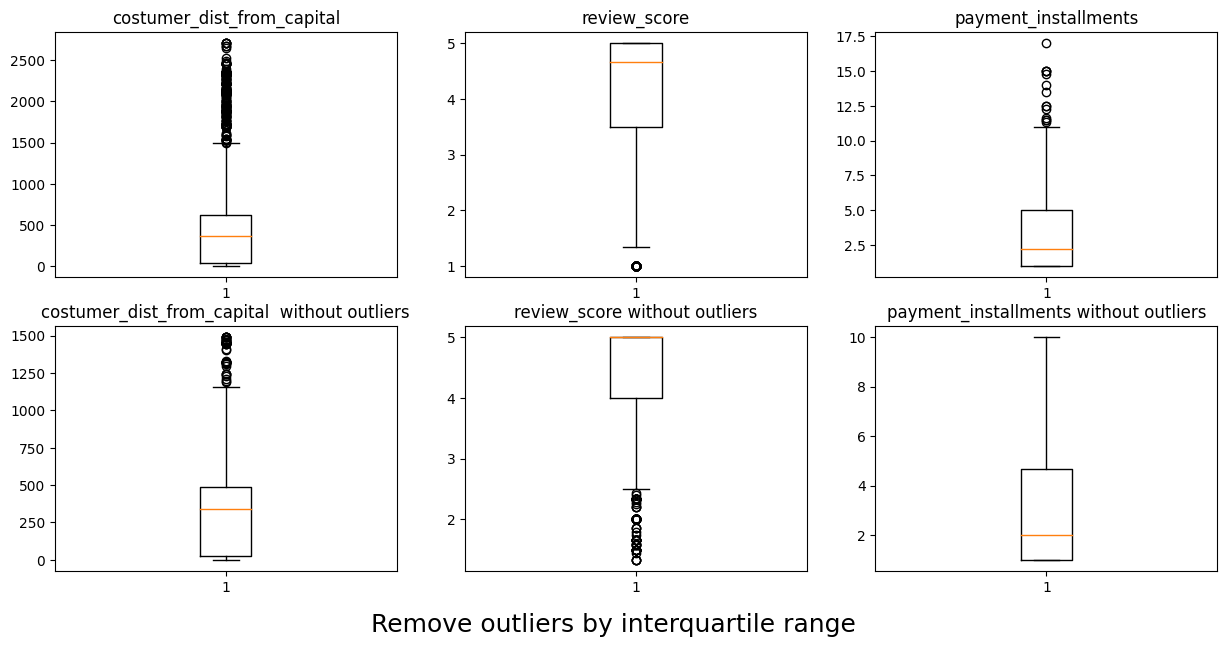

In [56]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0][0].boxplot(clientsPlus["costumer_dist_from_capital"])
axs[0][0].set_title("costumer_dist_from_capital")
axs[0][1].boxplot(clientsPlus["review_score"])
axs[0][1].set_title("review_score")
axs[0][2].boxplot(clientsPlus["payment_installments"])
axs[0][2].set_title("payment_installments")

fData = clientsPlus[col]

drop_interquartile_outliers(fData["costumer_dist_from_capital"], fData)
drop_interquartile_outliers(fData["review_score"], fData)
drop_interquartile_outliers(fData["payment_installments"], fData)

axs[1][0].boxplot(fData["costumer_dist_from_capital"])
axs[1][0].set_title("costumer_dist_from_capital  without outliers")
axs[1][1].boxplot(fData["review_score"])
axs[1][1].set_title("review_score without outliers")
axs[1][2].boxplot(fData["payment_installments"])
axs[1][2].set_title("payment_installments without outliers")
plt.suptitle("Remove outliers by interquartile range ", y=0.05, fontsize=18)
plt.show()

In [57]:
drop_interquartile_outliers(clientsPlus["costumer_dist_from_capital"],
                            clientsPlus)
drop_interquartile_outliers(clientsPlus["review_score"], clientsPlus)
drop_interquartile_outliers(clientsPlus["payment_installments"], clientsPlus)

In [58]:
from sklearn.preprocessing import RobustScaler

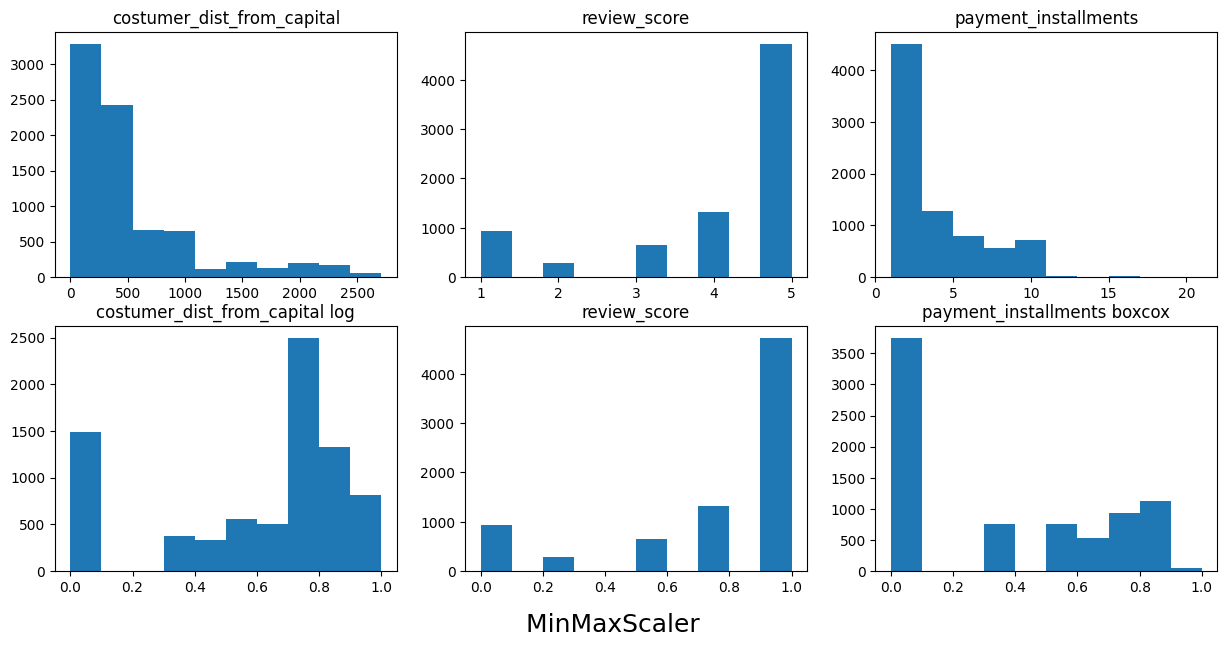

In [59]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0][0].hist(cData["costumer_dist_from_capital"])
axs[0][0].set_title("costumer_dist_from_capital")
axs[0][1].hist(cData["review_score"])
axs[0][1].set_title("review_score")
axs[0][2].hist(cData["payment_installments"])
axs[0][2].set_title("payment_installments")

fData = cData[col]
fData.loc[cData['costumer_dist_from_capital'] == 0,
          'costumer_dist_from_capital'] = 1
fData['costumer_dist_from_capital'] = \
    np.log(fData['costumer_dist_from_capital'])
fData["payment_installments"], lmb = \
    stats.boxcox(fData["payment_installments"])
scaler = MinMaxScaler()  # Standardization
fData[col] = scaler.fit_transform(fData[col])

axs[1][0].hist(fData["costumer_dist_from_capital"])
axs[1][0].set_title("costumer_dist_from_capital log")
axs[1][1].hist(fData["review_score"])
axs[1][1].set_title("review_score")
axs[1][2].hist(fData["payment_installments"])
axs[1][2].set_title("payment_installments boxcox")
plt.suptitle("MinMaxScaler ", y=0.05, fontsize=18)
plt.show()

In [60]:
cData.loc[cData['costumer_dist_from_capital'] == 0,
          'costumer_dist_from_capital'] = 1
cData['costumer_dist_from_capital_lg'] = \
    np.log(cData['costumer_dist_from_capital'])
cData["payment_installments_bx"], lmb = \
    stats.boxcox(cData["payment_installments"])
col = ["costumer_dist_from_capital_lg",
       "review_score", "payment_installments_bx"]
scaler = MinMaxScaler()  # Standardization
cData[col] = scaler.fit_transform(cData[col])

In [61]:
clientsPlus = (
    cData.groupby("customer_unique_id")
    .first()[RFM + col]
    .reset_index()
)

paymentGroups = \
    cData.groupby("customer_unique_id")["payment_installments_bx"].mean()

clientsPlus.loc[clientsPlus["customer_unique_id"] == paymentGroups.index,
                "payment_installments_bx"] = paymentGroups.values

reviewGroups = cData.groupby("customer_unique_id")["review_score"].mean()
clientsPlus.loc[clientsPlus["customer_unique_id"] == reviewGroups.index,
                "review_score"] = reviewGroups.values

clientsPlus.to_csv("clients+.csv", index=False)